In [68]:
import sys
sys.version

'3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]'

In [69]:
import numpy as np
import math
from collections import defaultdict

class QLearning:
    def __init__(self, n_states, n_actions,cfg):
        self.n_actions = n_actions 
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma  
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(n_actions)) # 用嵌套字典存放状态->动作->状态-动作值（Q值）的映射，即Q表


    def sample_action(self, state):
        # 采样动作，训练时用
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon 指数递减
        
        # epsilon-greedy 策略
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选择Q(s,a)最大 对应的动作
        else:
            action = np.random.choice(self.n_actions) # explore
        return action
    

    def predict_action(self,state):
        action = np.argmax(self.Q_table[str(state)])
        return action
    
    
    def update(self, state, action, reward, next_state, terminated):
        Q_predict = self.Q_table[str(state)][action] 
        if terminated: # 终止状态
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 

        # Q-learning
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)


In [70]:
def train(cfg, env, agent):
    print('开始训练！')
    print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}')
    rewards = []  

    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个回合的奖励
        state = env.reset(seed=cfg.seed)  # 重置环境,即开始新的回合
        while True:
            action = agent.sample_action(state)  # 根据算法采样一个动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 与环境进行一次动作交互
            agent.update(state, action, reward, next_state, terminated)  # Q学习算法更新
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        if (i_ep+1)%20==0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon:.3f}")
    print('完成训练！')
    return {"rewards":rewards}


def test(cfg, env, agent):
    print('开始测试！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}')
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset(seed=cfg.seed)  # 重置环境, 重新开一局（即开始新的一个回合）
        while True:
            action = agent.predict_action(state)  # 根据算法选择一个动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 与环境进行一个交互
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    return {"rewards":rewards}

In [71]:
import gymnasium as gym 
import turtle
import numpy as np

# turtle tutorial : https://docs.python.org/3.3/library/turtle.html

class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

In [72]:


import gymnasium as gym
def env_agent_config(cfg, seed=1):
    #创建环境和智能体
    env = gym.make(cfg.env_name)  
    env = CliffWalkingWapper(env)
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    agent = QLearning(n_states,n_actions,cfg)
    return env,agent



In [73]:
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.env_name =  'CliffWalking-v0' 
        self.algo_name = 'Q-Learning' 
        self.train_eps = 400 
        self.test_eps = 20 
        self.max_steps = 200 
        self.epsilon_start = 0.95 #  e-greedy策略中epsilon的初始值
        self.epsilon_end = 0.01 #  e-greedy策略中epsilon的最终值
        self.epsilon_decay = 300 #  e-greedy策略中epsilon的衰减率
        self.gamma = 0.9 # 折扣因子
        self.lr = 0.1 # 学习率
        self.seed = 1 # 随机种子

def smooth(data, weight=0.9):  
    #用于平滑曲线
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards))  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

开始训练！
环境:CliffWalking-v0, 算法:Q-Learning
回合：20/400，奖励：-183.0，Epsilon：0.010
回合：40/400，奖励：-56.0，Epsilon：0.010
回合：60/400，奖励：-58.0，Epsilon：0.010
回合：80/400，奖励：-40.0，Epsilon：0.010
回合：100/400，奖励：-53.0，Epsilon：0.010
回合：120/400，奖励：-38.0，Epsilon：0.010
回合：140/400，奖励：-32.0，Epsilon：0.010
回合：160/400，奖励：-17.0，Epsilon：0.010
回合：180/400，奖励：-21.0，Epsilon：0.010
回合：200/400，奖励：-24.0，Epsilon：0.010
回合：220/400，奖励：-18.0，Epsilon：0.010
回合：240/400，奖励：-20.0，Epsilon：0.010
回合：260/400，奖励：-14.0，Epsilon：0.010
回合：280/400，奖励：-13.0，Epsilon：0.010
回合：300/400，奖励：-15.0，Epsilon：0.010
回合：320/400，奖励：-118.0，Epsilon：0.010
回合：340/400，奖励：-13.0，Epsilon：0.010
回合：360/400，奖励：-13.0，Epsilon：0.010
回合：380/400，奖励：-13.0，Epsilon：0.010
回合：400/400，奖励：-13.0，Epsilon：0.010
完成训练！
开始测试！
环境：CliffWalking-v0, 算法：Q-Learning
回合数：1/20, 奖励：-13.0
回合数：2/20, 奖励：-13.0
回合数：3/20, 奖励：-13.0
回合数：4/20, 奖励：-13.0
回合数：5/20, 奖励：-13.0
回合数：6/20, 奖励：-13.0
回合数：7/20, 奖励：-13.0
回合数：8/20, 奖励：-13.0
回合数：9/20, 奖励：-13.0
回合数：10/20, 奖励：-13.0
回合数：11/20, 奖励：-13.0
回合数：12/20, 奖励：-13.0
回合数：1

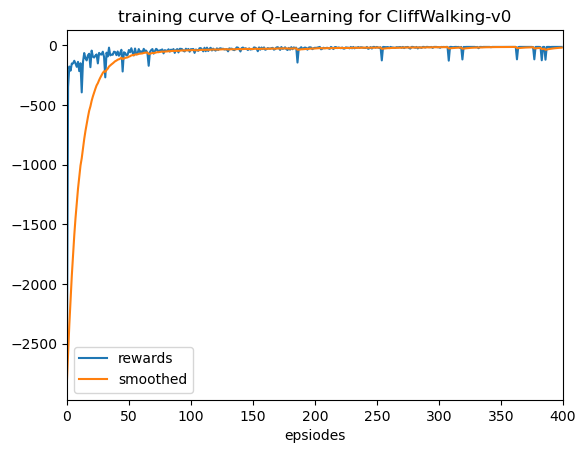

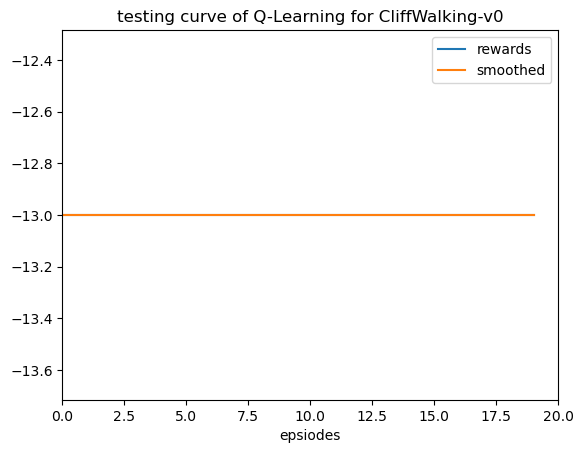

In [74]:
cfg = Config() 
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve of {cfg.algo_name} for {cfg.env_name}")  
res_dic = test(cfg, env, agent)

plot_rewards(res_dic['rewards'], title=f"testing curve of {cfg.algo_name} for {cfg.env_name}")  # 画出结果



In [75]:
cfg = Config()
env = gym.make(cfg.env_name)  
env = CliffWalkingWapper(env)
n_states = env.observation_space.n 
n_actions = env.action_space.n 
agent = QLearning(n_states,n_actions,cfg)

state = env.reset(seed=cfg.seed)  # 重置环境, 重新开一局（即开始新的一个回合）
while True:
    action = agent.predict_action(state)  # 根据算法选择一个动作
    next_state, reward, terminated, truncated, info = env.step(action)  # 与环境进行一个交互
    state = next_state  # 更新状态
    env.render()
    if terminated or truncated:
        break

/home/ww/anaconda3/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(


Terminator: 